### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import skimage.io as io

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [5]:
from preprocess.common import load_nii

### Generate Dataframe with all data info

In [6]:
if environ.get('MMsCardiac_DATA_PATH') is not None:
    MMs_DATA_PATH = environ.get('MMsCardiac_DATA_PATH')
else:
    print("Please set the environment variable MMs_DATA_PATH. Read the README!")

In [7]:
data_info_path = os.path.join(MMs_DATA_PATH, "Training-corrected", "M&Ms Dataset Information.xlsx")
data_info_df = pd.read_excel(data_info_path)
data_info_df.head()

,External code,Vendor,Centre,ED,ES
0,A0S9V9,A,1,0,9
1,A1D0Q7,B,2,0,9
2,A1D9Z7,A,1,22,11
3,A1E9Q1,A,1,0,9
4,A1O8Z3,B,3,23,10


In [8]:
data_info_df["Labeled"] = False
for index, row in data_info_df.iterrows():
    if os.path.exists(os.path.join(MMs_DATA_PATH, "Training-corrected", "Labeled", row["External code"])):
        data_info_df.at[index, 'Labeled'] = True
    elif not os.path.exists(os.path.join(MMs_DATA_PATH, "Training-corrected", "Unlabeled", row["External code"])):
        assert False, "Not labeled or unlabeled case '{}'?".format(row["External code"])

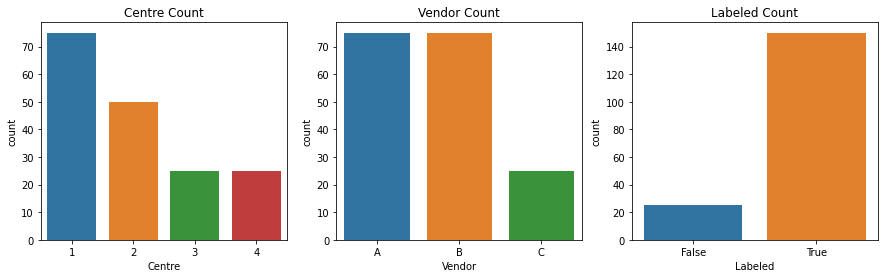

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_title("Centre Count")
sns.countplot(data_info_df["Centre"], ax=ax1)
ax2.set_title("Vendor Count")
sns.countplot(data_info_df["Vendor"], ax=ax2)
ax3.set_title("Labeled Count")
sns.countplot(data_info_df["Labeled"], ax=ax3)

In [10]:
data_info_df["Type"] = "Delete"
data_info_df["Phase"] = -1

for index, row in data_info_df.iterrows():
    
    if row["ED"]==-1: break  # We are at 'new' items
        
    data_info_df.loc[len(data_info_df)] = {
        "External code": row["External code"], "Vendor": row["Vendor"], 
        "Centre": row["Centre"], "ED": -1, "ES": -1, "Labeled": row["Labeled"],
        "Type": "ED", "Phase": row["ED"]
    }
    
    data_info_df.loc[len(data_info_df)] = {
        "External code": row["External code"], "Vendor": row["Vendor"], 
        "Centre": row["Centre"], "ED": -1, "ES": -1, "Labeled": row["Labeled"],
        "Type": "ES", "Phase": row["ES"]
    }
    

data_info_df = data_info_df[data_info_df["Type"] != "Delete"]
data_info_df = data_info_df.drop(columns=['ED', 'ES'])
data_info_df = data_info_df.reset_index(drop=True)

In [ ]:
data_info_df["Slice"] = -1

for index, row in data_info_df.iterrows():
    
    if row["Slice"]!=-1: 
        print("Done")
        break  # We are at 'new' items
        
    img_example = data_info_df.loc[index]["External code"]
    img_example = os.path.join(
        MMs_DATA_PATH, "Training-corrected", "Labeled" if row["Labeled"] else "Unlabeled", 
        img_example, "{}_sa.nii.gz".format(img_example)
    )
    
    num_slices = load_nii(img_example)[0].shape[2]
    
    for c_slice in range(num_slices):
        
        data_info_df.loc[len(data_info_df)] = {
            "External code": row["External code"], "Vendor": row["Vendor"], 
            "Centre": row["Centre"], "Labeled": row["Labeled"],
            "Type": row["Type"], "Phase": row["Phase"], "Slice": c_slice
        }


data_info_df = data_info_df[data_info_df["Slice"] != -1]
data_info_df = data_info_df.reset_index(drop=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_title("Centre Count")
sns.countplot(data_info_df["Centre"], ax=ax1)
ax2.set_title("Vendor Count")
sns.countplot(data_info_df["Vendor"], ax=ax2)
ax3.set_title("Labeled Count")
sns.countplot(data_info_df["Labeled"], ax=ax3)

In [ ]:
os.makedirs("../utils/data", exist_ok=True)
data_info_df.to_csv("../utils/data/train.csv", index=False)

In [12]:
df = pd.read_csv("../utils/data/train.csv")

In [13]:
df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


## Explore dataset

In [14]:
import nibabel as nib

In [15]:
def load_nii(img_path):
    nimg = nib.load(img_path)
    # return np.asanyarray(nimg.dataobj), nimg.affine, nimg.header
    return np.asanyarray(nimg.dataobj)

In [16]:
idx = 0

### Load Mask

In [17]:
if data_info_df.loc[idx]["Labeled"]:
    mask_example = data_info_df.loc[idx]["External code"]
    mask_example = os.path.join(
        MMs_DATA_PATH, "Training-corrected-contours", "Labeled", 
        mask_example, "{}_sa_gt.nii.gz".format(mask_example)
    )
    mask = load_nii(mask_example)
else:
    assert False, "Case {} not labeled!".format(data_info_df.loc[idx]["External code"])

In [18]:
print("-- Mask stats --")
print("Shape: {}".format(mask.shape))
print("Slices: {}".format(mask.shape[2]))
print("Phases: {}".format(mask.shape[3]))
print("Values: {}".format(np.unique(mask)))
print("Labels are: 1 (LV), 2 (MYO) and 3 (RV).")

-- Mask stats --
Shape: (216, 256, 13, 25)
Slices: 13
Phases: 25
Values: [0. 1. 2. 3.]
Labels are: 1 (LV), 2 (MYO) and 3 (RV).


### Load IMG

In [19]:
if data_info_df.loc[idx]["Labeled"]:
    img_example = data_info_df.loc[idx]["External code"]
    img_example = os.path.join(
        MMs_DATA_PATH, "Training-corrected", "Labeled", 
        img_example, "{}_sa.nii.gz".format(img_example)
    )
    img = load_nii(img_example)
else:
    assert False, "Case {} not labeled!".format(data_info_df.loc[idx]["External code"])

In [20]:
print("-- IMG stats --")
print("Shape: {}".format(img.shape))
print("Slices: {}".format(img.shape[2]))
print("Phases: {}".format(img.shape[3]))
print("Values: Min {} / Max {}".format(img.min(), img.max()))

-- IMG stats --
Shape: (216, 256, 13, 25)
Slices: 13
Phases: 25
Values: Min 0.0 / Max 2629.0


### Overlay

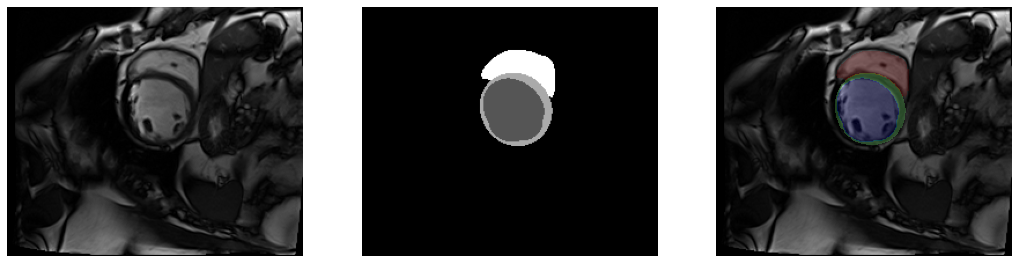

In [21]:
c_slice = 6
c_phase = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(img[..., c_slice, c_phase], cmap="gray")
ax2.imshow(mask[..., c_slice, c_phase], cmap="gray")

masked = np.ma.masked_where(mask[..., c_slice, c_phase] == 0, mask[..., c_slice, c_phase])
ax3.imshow(img[..., c_slice, c_phase], cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)

### Get Samples

In [35]:
save_path = "samples"
os.makedirs(save_path, exist_ok=True)

In [22]:
df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


In [27]:
base_dir = MMs_DATA_PATH = os.environ.get('MMsCardiac_DATA_PATH')
data_parent = os.path.join("Training-corrected", "Labeled_npy")

In [50]:
d_slice = 6
d_phase = 7
info = "_badPhase"
total_count = 0
d_samples = 5

for vendor in ["A", "B"]:
    
    count = 0
    
    for index, row in df.iterrows():
        if row["Vendor"]==vendor and row["Phase"]==d_phase and row["Slice"]==d_slice:

            external_code = row["External code"]

            mask_path = os.path.join(
                base_dir, "Training-corrected-contours", "Labeled_npy",
                external_code, "{}_slice{}_phase{}.npy".format(external_code, d_slice, d_phase)
            )
            mask = np.load(mask_path)

            img_path = os.path.join(
                base_dir, data_parent,
                external_code, "{}_slice{}_phase{}.npy".format(external_code, d_slice, d_phase)
            )
            image = np.load(img_path)

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
            ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

            ax1.imshow(image, cmap="gray")
            ax2.imshow(mask, cmap="gray")

            masked = np.ma.masked_where(mask == 0, mask)
            ax3.imshow(image, cmap="gray")
            ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
            plt.savefig(
                os.path.join(save_path, "{}_slice{}_phase{}_vendor{}{}.jpg".format(external_code, d_slice, d_phase, vendor,info)),
                bbox_inches='tight', dpi=160
            )
            plt.close()

            count += 1
            total_count += 1
            if count==d_samples:
                break

print("Got {} samples".format(total_count))

Got 8 samples


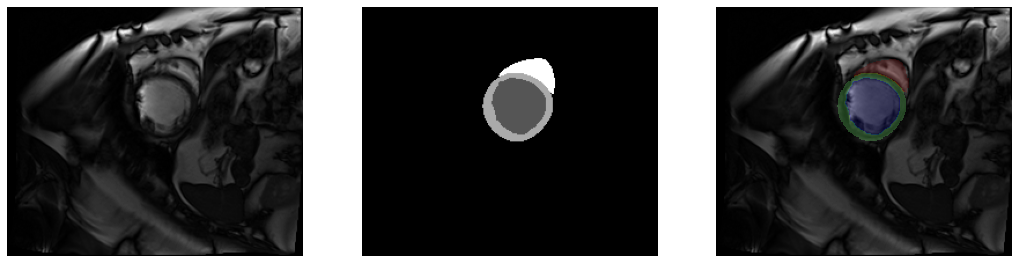

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

ax1.imshow(image, cmap="gray")
ax2.imshow(mask, cmap="gray")

masked = np.ma.masked_where(mask == 0, mask)
ax3.imshow(image, cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
plt.savefig(
    os.path.join(save_path, "{}_slice{}_phase{}_vendor{}.jpg".format(external_code, d_slice, d_phase, vendor)),
    bbox_inches='tight', dpi=160
)

### Dataloader

1. Only labeled data
2. Fold cross validation with equal Vendor Distribution

#### 1. Only labeled data

In [8]:
data_info_df = pd.read_csv("../utils/data/train.csv")

In [9]:
data_info_df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


In [10]:
labeled_df = data_info_df[data_info_df['Labeled']]
labeled_df = labeled_df.reset_index(drop=True)

#### 2. Fold cross validation

In [26]:
from sklearn.model_selection import StratifiedKFold, GroupKFold

In [17]:
fold = 4
mode="validation"
fold_splits = 5

if fold >= fold_splits:
    assert False, "Wrong Fold number (can't bre greater than total folds)"

skf = StratifiedKFold(n_splits=fold_splits)
target = labeled_df["Vendor"]

for fold_indx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(target)), target)):
    if fold_indx == fold:  # If current iteration is the desired fold, take it!
        fold_df_tr = labeled_df.loc[train_index]
        fold_df_val = labeled_df.loc[val_index]

fold_df_tr = fold_df_tr.reset_index(drop=True)
fold_df_val = fold_df_val.reset_index(drop=True)

In [ ]:
print("Vendor Tr: \n{}".format(fold_df_tr["Vendor"].value_counts()))
print("\nVendor Val: \n{}".format(fold_df_val["Vendor"].value_counts()))

In [ ]:
tr_pats = np.unique(fold_df_tr["External code"])
val_pats = np.unique(fold_df_val["External code"])
print("Overlapping patients: {}".format(np.intersect1d(tr_pats, val_pats)))

In [ ]:
skf = GroupKFold(n_splits=fold_splits)
target = labeled_df["Vendor"]
for fold_indx, (train_index, val_index) in enumerate(
        skf.split(np.zeros(len(target)), target, groups=labeled_df["External code"])):
    if fold_indx == fold:  # If current iteration is the desired fold, take it!
        fold_df_tr = labeled_df.loc[train_index]
        fold_df_val = labeled_df.loc[val_index]

fold_df_tr = fold_df_tr.reset_index(drop=True)
fold_df_val = fold_df_val.reset_index(drop=True)

In [20]:
print("Vendor Tr: \n{}".format(fold_df_tr["Vendor"].value_counts()))
print("\nVendor Val: \n{}".format(fold_df_val["Vendor"].value_counts()))

Vendor Tr: 
A    1391
B    1237
Name: Vendor, dtype: int64

Vendor Val: 
A    347
B    309
Name: Vendor, dtype: int64


In [24]:
tr_pats = np.unique(fold_df_tr["External code"])
val_pats = np.unique(fold_df_val["External code"])
print("Overlapping patients: {}".format(np.intersect1d(tr_pats, val_pats)))

Overlapping patients: ['I2K2Y8' 'L1Q9V8']


In [28]:
skf = GroupKFold(n_splits=fold_splits)
target = labeled_df["Vendor"]
for fold_indx, (train_index, val_index) in enumerate(
        skf.split(np.zeros(len(target)), target, groups=labeled_df["External code"])):
    if fold_indx == fold:  # If current iteration is the desired fold, take it!
        fold_df_tr = labeled_df.loc[train_index]
        fold_df_val = labeled_df.loc[val_index]

fold_df_tr = fold_df_tr.reset_index(drop=True)
fold_df_val = fold_df_val.reset_index(drop=True)

In [29]:
print("Vendor Tr: \n{}".format(fold_df_tr["Vendor"].value_counts()))
print("\nVendor Val: \n{}".format(fold_df_val["Vendor"].value_counts()))

Vendor Tr: 
A    1436
B    1190
Name: Vendor, dtype: int64

Vendor Val: 
B    356
A    302
Name: Vendor, dtype: int64


In [30]:
tr_pats = np.unique(fold_df_tr["External code"])
val_pats = np.unique(fold_df_val["External code"])
print("Overlapping patients: {}".format(np.intersect1d(tr_pats, val_pats)))

Overlapping patients: []


### Check shapes distribution

In [18]:
shapes, count = {}, 0
for idx in range(len(data_info_df)):
    if data_info_df.loc[idx]["Labeled"]:
        img_example = data_info_df.loc[idx]["External code"]
        img_example = os.path.join(
            MMs_DATA_PATH, "Training-corrected", "Labeled", 
            img_example, "{}_sa.nii.gz".format(img_example)
        )
        img = load_nii(img_example)
        count+=1
        if img.shape[0:2] not in shapes:
            shapes[img.shape[0:2]] = 1
        else:
            shapes[img.shape[0:2]] += 1
    else:
        pass
        #assert False, "Case {} not labeled!".format(data_info_df.loc[idx]["External code"])

# Convert key shapes (tuple) to string ==> matplot
shapes = {str(k):int(v) for k,v in shapes.items()}

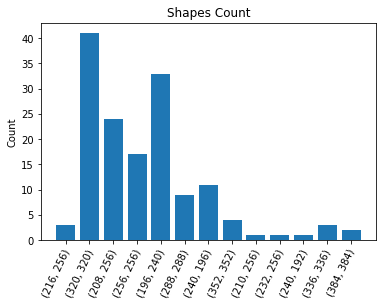

In [19]:
plt.title("Shapes Count")
plt.ylabel("Count")
ax = plt.bar(shapes.keys(), shapes.values())
plt.xticks(rotation=65)

# Move a bit xticks/labels
ax  = plt.gca()
trans = mtrans.Affine2D().translate(-10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

In [20]:
print("Total labeled: {}".format(count))
print("Match: {}".format(np.array(list(shapes.values())).sum()==count))

Total labeled: 150
Match: True
